# Miniproject - Neuroscience: cellular and circuit mechanisms (BIO-482)

- This notebook produces the figures for **part 2** of the miniproject.

#### Importing libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

#### Importing helper functions
 Feel free to check out what these functions do in the corresponding files, `helpers.py` or `utils.py`. 
 - `helpers.py` contains functions to analyze membrane potential recording data
 - `utils.py` contains functions useful for other things e.g. plotting

In [2]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

# Load data
Load previously saved dataframe as `.csv` file:

In [3]:
# Make paths
main_dir = r'/Users/wesleymonteith/code/bio482_miniproject' # EDIT
print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'python', 'figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, 'python/data') #if your folder is organized differently, just specify the full path to the .mat file

fname = 'data_bio482.pkl'
data_df = pd.read_pickle(os.path.join(data_path, fname))

Main working directory: /Users/wesleymonteith/code/bio482_miniproject


# Part 2 - Membrane potential dynamics and motor activity [2/10 marks]

Set general general parameters that we will use throughout **part 2**:

In [4]:
sweep_type = 'free whisking'

pre_window = 0.5 # time before whisking onset (s)
post_window = 0.5 # time after whisking onset (s)
min_event_dur = 0.2 # minimal duration of whisking episode to be considered
min_iti = 0.5 # minimal intertrial interval (ITI) between 2 consecutive whisking episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.05 # bin size for psth (s)
epoch_bounds = {'pre':[-0.5, -0.3],
                  'post':[0,0.2]}  # time boundaries to compute changes in whisker protraction (WP), or Vm

 Select data for specific one sweep type (sweep and trial are synonymous):

In [5]:
data_df_subset = data_df[data_df['Sweep_Type']==sweep_type] 

Find all the unique recorded cells present in the data:

In [6]:
all_cells = np.unique(data_df_subset.Cell_ID)
print('Number of cells:', len(all_cells))

Number of cells: 232


# Here we start the analysis
- Here, we iterate over cells and trials per cell to compute, collect relevant data.

In [7]:
verbose=0 #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict = {'cell_id': all_cells, 
          'cell_type':[], 
          # This is a template, an example with whisker protraction
          'numb_events': [],
          'wp_avg': [],
          'wp_amplitude_pre': [],
          'wp_amplitude_post': [],
          # Sub. Vm
          'vm_avg': [], 
          'vm_amplitude_pre': [],
          'vm_amplitude_post': [],
          # Firing rates
          'ap_avg':[],
          'ap_psth':[],
          'ap_fr_pre':[],
          'ap_fr_post':[]
        }
    
# Iterate over each cell identities to collect desired data
for idx, cell in enumerate(np.unique(data_df_subset.Cell_ID)):
    if idx%100==0:
        print('Cell {}/{}'.format(idx, np.unique(data_df_subset.Cell_ID).shape[0]))
    
    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])
    
    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]
    
    # Get cell type 
    cell_type = cell_df.Cell_Type.values[0]
    result_dict['cell_type'] += [cell_type]
    
    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values
    
    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration=0
    tot_number_ap=0
    
    # Initialize empty lists to get data for each trial/sweep
    tot_ap_thresh = []
    tot_ap_duration= []
    
    # Template
    tot_wp_events = []
    
    # Vm and AP FR
    tot_vm_events = []
    tot_ap_events = []
    
    ## For that cell, iterate over trials
    for trial in trial_list:
        
        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]
        
        # Get event times for that trial
        event_times = cell_trial_df['Sweep_WhiskingTimes'].values[0]

        if event_times is None: # skip when there are no events
            continue
        
        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]
        
        # Template: extract whisker angle and sampling rate of whisker video data
        whisker_angle = cell_trial_df['Sweep_WhiskerAngle'].values[0]
        sr_wp = cell_trial_df['Sweep_WhiskerAngle_SamplingRate'].values[0]
        
         # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        tot_rec_duration += trial_rec_duration
        
        # Detection of action potentials for that trial, and update total number of APs for that cell
        #ap_params = None
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh) 
        tot_number_ap += ap_params.shape[0]
        
                
        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

             #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
            
            #For APs, make an analog binary vector of same dimensions as Vm_Sub
            vec_length = len(vm_sub)
            ap_vect = Function_Times2Vect(ap_peak_times, sr_vm, vec_length)
            
        # Else if no AP, subthreshold Vm is just Vm
        else:
            vm_sub = membrane_potential.copy()
            ap_vect = np.zeros_like(vm_sub) #empty vector of size Vm_Sub
            
        # Once trial event times and data is collected, use this function to extract data aligned to event onset
        # -> check function (Function_Event_Triggered_Signal) parameters and code!
        # -> input data can be whatever, given a certain dimensions
        # -> events can be whatever
        # -> adjust sampling rate for data type (e.g. video, Vm)! 
        
        wp_event = Function_Event_Triggered_Signal(whisker_angle, sr_wp, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        vm_event = Function_Event_Triggered_Signal(vm_sub, sr_vm, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        ap_event = Function_Event_Triggered_Signal(np.squeeze(ap_vect), sr_vm, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)


        # Missing data in original .mat file is encoded as -1, so this skips entires with missing data
        if type(wp_event) == int:
            continue
        if type(vm_event) == int:
            continue
        if type(ap_event) == int:
            continue
                 
        # Append each event-triggered vector and stack to an array 
        tot_wp_events += [wp_event]
        tot_wp_array = np.hstack(tot_wp_events)
        
        tot_vm_events+= [vm_event]
        tot_vm_array=np.hstack(tot_vm_events)
        
        tot_ap_events+= [ap_event]
        tot_ap_array=np.hstack(tot_ap_events)
        

    # Compute means only if a certain number of trials is present
    n_events = tot_wp_array.shape[1]
    if (n_events >= min_number_trials):
        result_dict['numb_events'] += [n_events] 
        
        # Calculate trial-averaged signals
        #Template: WP
        wp_avg = np.mean(tot_wp_array, 1) 
        result_dict['wp_avg'] += [wp_avg] #add for that cell
        
        vm_avg = np.mean(tot_vm_array, 1) 
        result_dict['vm_avg'] += [vm_avg]
        
        ap_avg = np.mean(tot_ap_array, 1) 
        result_dict['ap_avg'] += [ap_avg]
        
        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]
        
        
        #for epoch in range(wp_bounds.shape[0]): 
        for epoch in epoch_bounds.keys():
            
            # Template: whisker protraction
            # Get bound of that epoch (pre/post)
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_wp))
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_wp-1))
            
            #Get mean in pre/post epoch
            if epoch=='pre':
                result_dict['wp_amplitude_pre'] += [wp_avg[bound_1:bound_2].mean(0)]
            else:
                result_dict['wp_amplitude_post'] += [wp_avg[bound_1:bound_2].mean(0)]
                
            # Vm, and AP firing rate
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_vm)) #sr_vm !
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_vm-1))
            
            if epoch=='pre':
                result_dict['vm_amplitude_pre'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in mV!
                result_dict['ap_fr_pre'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]       #in Hz!
            else:
                result_dict['vm_amplitude_post'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in Hz!
                result_dict['ap_fr_post'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]
                
                
    #If there are less trials than necessary, set to NaNs (exclude data)
    else:
        result_dict['numb_events'] += [n_events]
        
        #Template: WP
        wp_avg=np.nan*np.empty_like(wp_avg)
        result_dict['wp_avg'] += [wp_avg]
        result_dict['wp_amplitude_pre'] += [np.nan]
        result_dict['wp_amplitude_post'] += [np.nan]
        
        # VM
        vm_avg=np.nan*np.empty_like(vm_avg)
        result_dict['vm_avg'] += [vm_avg]
        result_dict['vm_amplitude_pre'] += [np.nan]
        result_dict['vm_amplitude_post'] += [np.nan]
        
        #AP firing rate
        ap_avg=np.nan*np.empty_like(ap_avg)
        result_dict['ap_avg'] += [ap_avg]
        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict['ap_psth'] += [ap_psth[:,1]]
        
        result_dict['ap_fr_pre'] += [np.nan]
        result_dict['ap_fr_post'] += [np.nan]

                         
# Convert each dictionary lists as numpy arrays
result_dict = {key: np.array(result_dict[key]) for key in result_dict.keys()}

#Init. dataframe size
result_df = pd.DataFrame(index=range(np.unique(data_df_subset.Cell_ID).shape[0]),
             columns=result_dict.keys())

for key in result_dict.keys():
    result_df[key] = result_dict[key] #this works for scalars
    
# For array-based data, one must give a list to assign to dataframe column
# Template: WP
result_df['wp_avg'] = list(result_dict['wp_avg'])

result_df['vm_avg'] = list(result_dict['vm_avg'])
result_df['ap_avg'] = list(result_dict['ap_avg'])
result_df['ap_psth'] = list(result_dict['ap_psth'])

# times for the bins of the psth
psth_time=ap_psth[:,0]

print('Done!')

Cell 0/232


/Users/wesleymonteith/code/bio482_miniproject/python/scripts/helpers.py:52: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal
/Users/wesleymonteith/code/bio482_miniproject/python/scripts/helpers.py:18: RuntimeWarning: invalid value encountered in divide
  AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))


Cell 100/232
Cell 200/232
Done!


Before we proceed, let's **inspect** the resulting dataframe:

In [8]:
result_df.head(1)

,cell_id,cell_type,numb_events,wp_avg,wp_amplitude_pre,wp_amplitude_post,vm_avg,vm_amplitude_pre,vm_amplitude_post,ap_avg,ap_psth,ap_fr_pre,ap_fr_post
0,AP032_1,PV,17,"[-139.3472117647059, -139.41210588235293, -139...",-139.536777,-135.226516,"[-0.056839968932773106, -0.056852848647058835,...",-55.504155,-55.39956,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[27.058823529411764, 22.352941176470583, 18.82...",23.241104,27.06559


In [9]:
result_df.describe() #only sclar numeric columns

,numb_events,wp_amplitude_pre,wp_amplitude_post,vm_amplitude_pre,vm_amplitude_post,ap_fr_pre,ap_fr_post
count,232.000000,227.000000,227.000000,227.000000,227.000000,227.000000,227.000000
mean,13.383621,123.689431,132.047720,-54.643642,-54.114195,9.102246,11.401671
std,13.641492,122.426915,123.283273,6.141309,6.142742,14.602046,19.113221
min,1.000000,-159.831002,-154.083329,-73.221460,-69.755833,0.000000,0.000000
25%,6.000000,8.371459,16.571679,-57.903595,-57.921262,0.741944,0.222388
50%,10.000000,190.375651,198.731700,-54.157960,-53.767577,3.500875,3.750938
75%,15.000000,195.854284,204.561658,-50.321843,-50.401077,10.873931,13.577529
max,102.000000,211.854817,223.815249,-36.328027,-31.185084,139.701592,165.708094


# Plots
Let's just define a dictionary for color coding cell classes:

In [10]:
class_color = {'EXC':'k',
               'PV':'indianred',
               'VIP':'royalblue',
               'SST':'darkorange'} 
cell_class_order = ['EXC', 'PV', 'VIP', 'SST']

We are interested in computing **two quantities**:
1. The trial-averaged signal, averaged over cells (termed a "grand average"), aligned (centered) at the event onset for 1 second. This gives a vector.
2. The difference between the mean value of that signal, calculated in two different windows, before and after event onset. This gives a scalar.

We can compute these quantities for different types of signals, behavioral or neural.

## 1. Grand-averages aligned at event onset

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_35260/856734313.py:24: RuntimeWarning: Mean of empty slice
  baseline_arr = np.nanmean(arr_cell_type[int(bound_1):int(bound_2)], axis=0) #a scalar


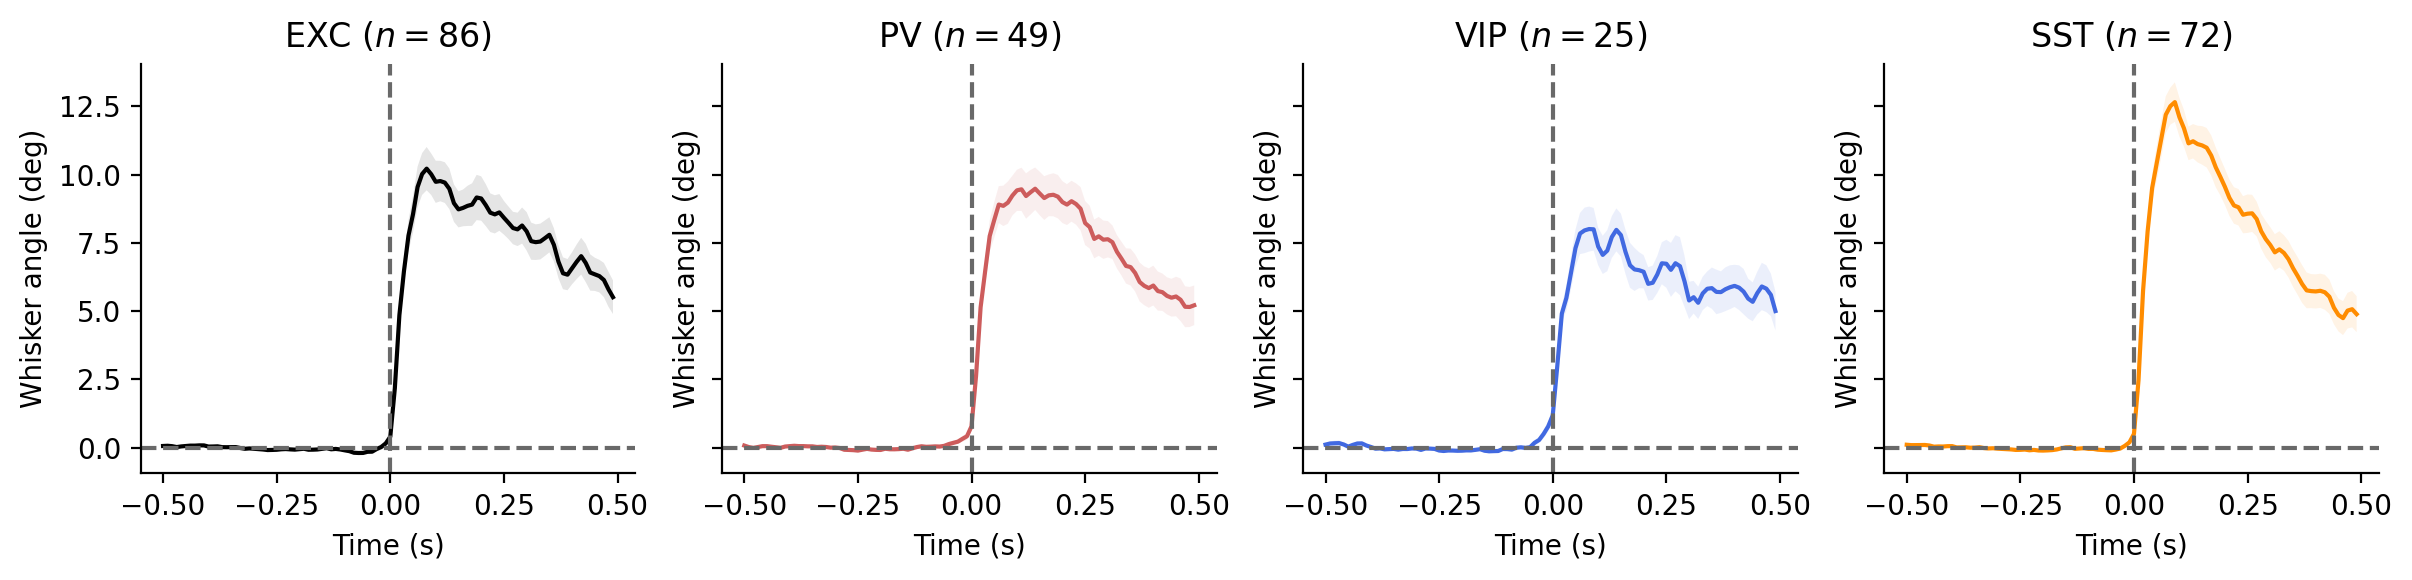

In [11]:
# Parameters for plotting and baseline calculation
time_before = -0.5
baseline_bounds = [-0.5, -0.2] 

#Define 1x4 plot to show each cell type
fig, axs = plt.subplots(1,4, figsize=(12,3), dpi=200,
                       sharey=True)
for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
#Define a time vector for plotting
time = np.arange((pre_window + post_window)*sr_wp) / sr_wp - pre_window #note sampling rate!

#Iterate over cell types
for idx, cell_type in enumerate(cell_class_order):
    
    # Make array with cell-type-specific data
    arr_cell_type = np.stack(result_df[result_df.cell_type==cell_type]['wp_avg'].values,axis=1)

    # Remove baseline (=average signal before event onset) from mean signal
    bound_1 = (baseline_bounds[0]-time_before)*sr_wp
    bound_2 = (baseline_bounds[1]-time_before)*sr_wp-1
    baseline_arr = np.nanmean(arr_cell_type[int(bound_1):int(bound_2)], axis=0) #a scalar
    arr_cell_type = arr_cell_type - baseline_arr #substract baseline value to all cells
    
   
    # Get mean (across cells) event-triggered trial-averaged signal, and SEM
    mean = np.nanmean(arr_cell_type, axis=1)
    n_cells = arr_cell_type.shape[1]
    sem = np.nanstd(arr_cell_type, axis=1) / np.sqrt(n_cells) #formula of standard error of the mean
    
    # Plot mean and confidence interval
    axs[idx].plot(time, np.nanmean(arr_cell_type, axis=1), color=class_color[cell_type])
    axs[idx].fill_between(time,
                          y1=mean-sem, 
                          y2=mean+sem,
                          color=class_color[cell_type],
                          alpha=0.1,
                          edgecolor=None)
    
    #Add additional information
    axs[idx].axvline(0, ls='--', c='dimgray')
    axs[idx].axhline(0, ls='--', c='dimgray')
    axs[idx].set_title(r'{} ($n={}$)'.format(cell_type, n_cells))
    axs[idx].set_ylabel('Whisker angle (deg)')
    axs[idx].set_xlabel('Time (s)')
                  
        
# Custom
plt.tight_layout()

# Save figure
fname = os.path.join(figure_path, '9_WhiskOnset_GRD_AVG_WhiskerAngle.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')

This shows how whisker angle recorded change, for different recordings that aimed to target different cell types. 
This is just an example baseline corrected signal, aligned to an event onset. To plot Vm, just to the same using `vm_avg`:

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_35260/126047943.py:24: RuntimeWarning: Mean of empty slice
  baseline_arr = np.nanmean(arr_cell_type[int(bound_1):int(bound_2)], axis=0) #a scalar


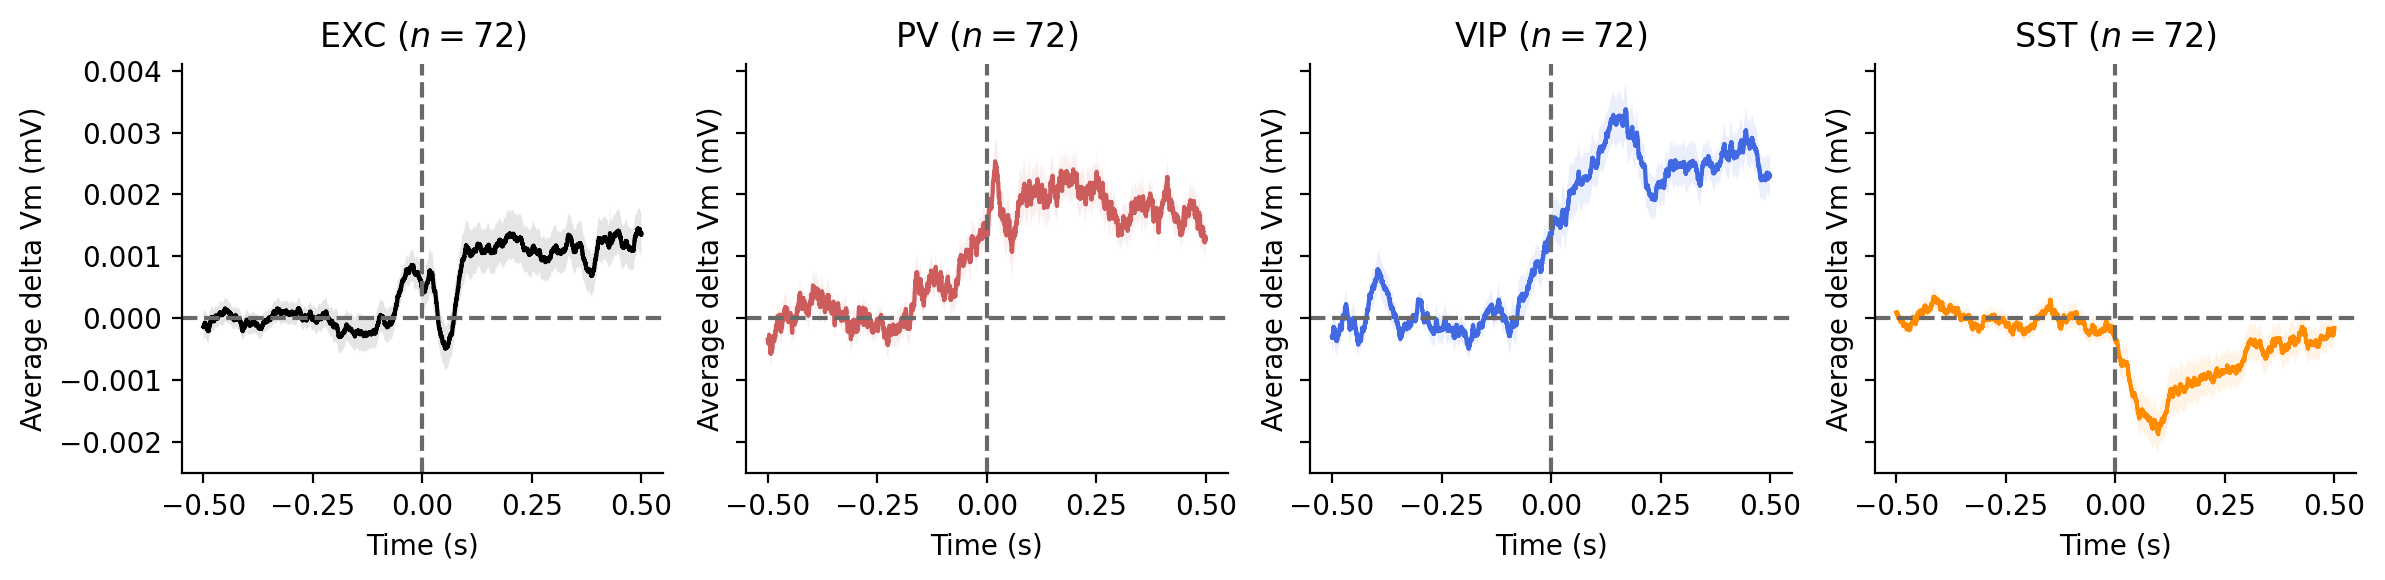

In [12]:
# Parameters for plotting and baseline calculation
time_before = -0.5
baseline_bounds = [-0.5, -0.2] 

#Define 1x4 plot to show each cell type
fig, axs = plt.subplots(1,4, figsize=(12,3), dpi=200,
                       sharey=True)
for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
#Define a time vector for plotting
time = np.arange((pre_window + post_window)*sr_vm) / sr_vm - pre_window #note sampling rate!

#Iterate over cell types
for idx, cell_type in enumerate(cell_class_order):
    
    # Make array with cell-type-specific data
    arr_cell_type = np.stack(result_df[result_df.cell_type==cell_type]['vm_avg'].values,axis=1)

    # Remove baseline (=average signal before event onset) from mean signal
    bound_1 = (baseline_bounds[0]-time_before)*sr_vm
    bound_2 = (baseline_bounds[1]-time_before)*sr_vm-1
    baseline_arr = np.nanmean(arr_cell_type[int(bound_1):int(bound_2)], axis=0) #a scalar
    arr_cell_type = arr_cell_type - baseline_arr #substract baseline value to all cells
    
    # Get mean (across cells) event-triggered trial-averaged signal, and SEM
    mean = np.nanmean(arr_cell_type, axis=1)
    n_trials = arr_cell_type.shape[1]
    sem = np.nanstd(arr_cell_type, axis=1) / np.sqrt(n_cells) #formula of standard error of the mean
    
    # Plot mean and confidence interval
    axs[idx].plot(time, np.nanmean(arr_cell_type, axis=1), color=class_color[cell_type])
    axs[idx].fill_between(time,
                          y1=mean-sem, 
                          y2=mean+sem,
                          color=class_color[cell_type],
                          alpha=0.1,
                          edgecolor=None)
    
    #Add additional information
    axs[idx].axvline(0, ls='--', c='dimgray')
    axs[idx].axhline(0, ls='--', c='dimgray')
    axs[idx].set_title(r'{} ($n={}$)'.format(cell_type, n_cells))
    axs[idx].set_ylabel('Average delta Vm (mV)')
    axs[idx].set_xlabel('Time (s)')
                  
        
# Custom
plt.tight_layout()

# Save figure
fname = os.path.join(figure_path, '9_WhiskOnset_GRD_AVG_Vm.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')

/var/folders/my/2hxsh9b90b9brv55p9f5x2700000gn/T/ipykernel_35260/610089613.py:25: RuntimeWarning: Mean of empty slice
  baseline_arr = np.nanmean(arr_cell_type[int(bound_1):int(bound_2)], axis=0) #a scalar


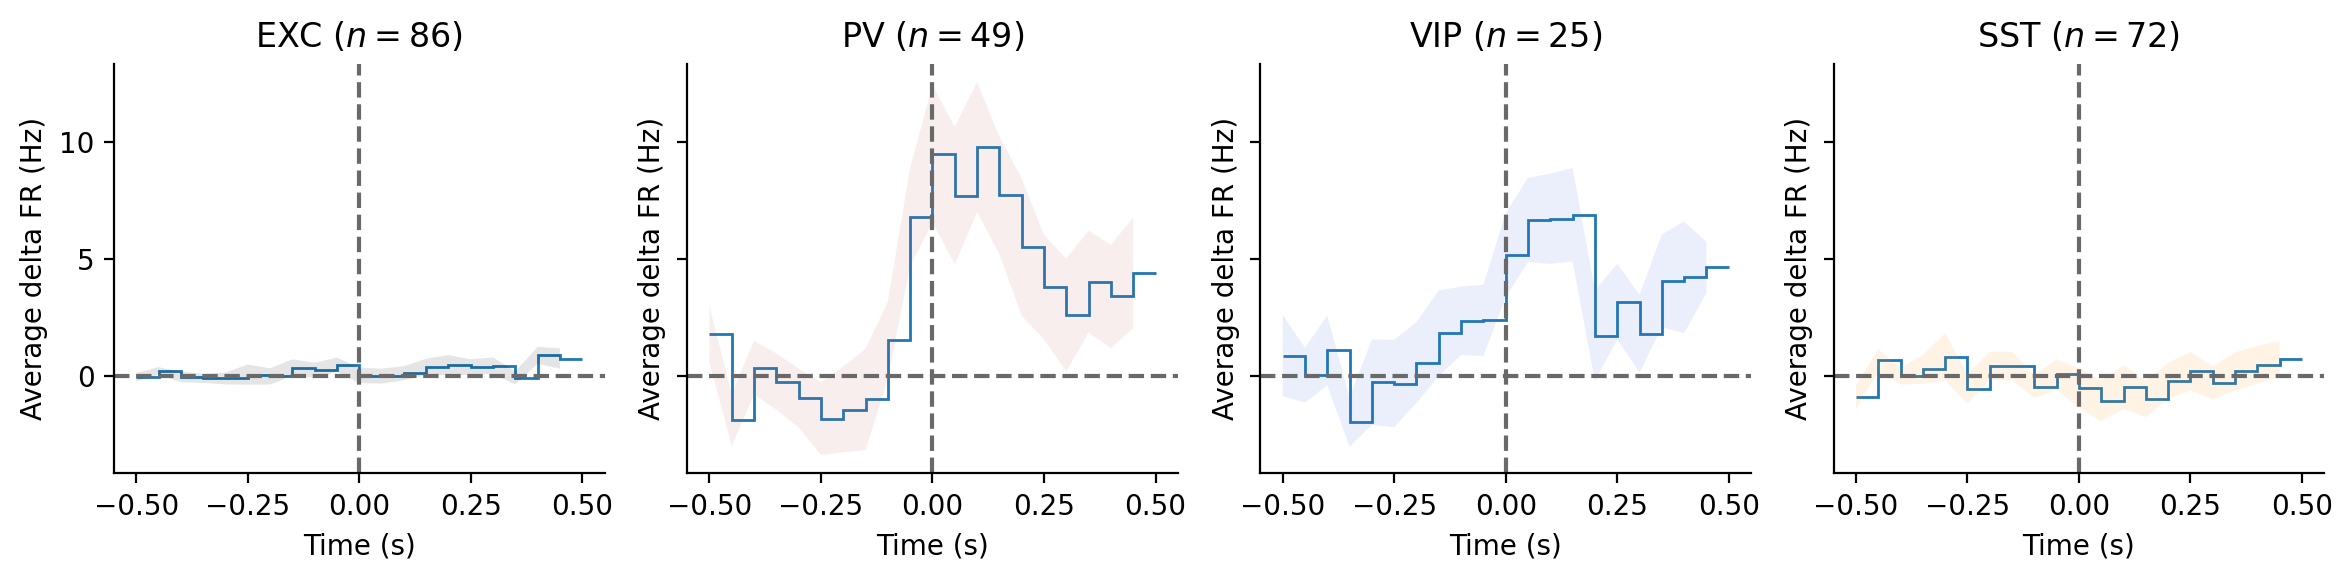

In [13]:
# Parameters for plotting and baseline calculation
time_before = -0.5
baseline_bounds = [-0.5, -0.2] 


#Define 1x4 plot to show each cell type
fig, axs = plt.subplots(1,4, figsize=(12,3), dpi=200,
                       sharey=True)
for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
#Define a time vector for plotting
psth_time_stairs=np.concatenate((psth_time, [0.5]), axis=0)

#Iterate over cell types
for idx, cell_type in enumerate(cell_class_order):
    
    # Make array with cell-type-specific data
    arr_cell_type = np.stack(result_df[result_df.cell_type==cell_type]['ap_psth'].values,axis=1)

    # Remove baseline (=average signal before event onset) from mean signal
    bound_1 = int((baseline_bounds[0]-time_before)/bin_size)
    bound_2 = int((baseline_bounds[1]-time_before)/bin_size-1)
    baseline_arr = np.nanmean(arr_cell_type[int(bound_1):int(bound_2)], axis=0) #a scalar
    arr_cell_type = arr_cell_type - baseline_arr #substract baseline value to all cells
    
    # Get mean (across cells) event-triggered trial-averaged signal, and SEM
    mean = np.nanmean(arr_cell_type, axis=1)
    n_cells = arr_cell_type.shape[1]
    sem = np.nanstd(arr_cell_type, axis=1) / np.sqrt(n_cells) #formula of standard error of the mean
    
    # Plot mean and confidence interval
    
    axs[idx].stairs(mean, psth_time_stairs, baseline=None)
    axs[idx].fill_between(psth_time,
                          y1=mean-sem, 
                          y2=mean+sem,
                          color=class_color[cell_type],
                          alpha=0.1,
                          edgecolor=None)
    
    # Add additional information
    axs[idx].axvline(0, ls='--', c='dimgray')
    axs[idx].axhline(0, ls='--', c='dimgray')
    axs[idx].set_title(r'{} ($n={}$)'.format(cell_type, n_cells))
    axs[idx].set_ylabel('Average delta FR (Hz)')
    axs[idx].set_xlabel('Time (s)')
                  
        
# Custome
plt.tight_layout()

# Save figure
fname = os.path.join(figure_path, '9_WhiskOnset_GRD_AVG_FirinRate.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')

## 2. Difference in magnitude pre and post event onset
Calculate **differences between post and pre** event onset:

Our dataframe contains the calculated quantities of interest.
This is how we could plot using `seaborn`:

In [14]:
#Template: calculte post-pre difference in WP as a new column to dataframe
result_df['delta_wp'] = result_df['wp_amplitude_post'] - result_df['wp_amplitude_pre']

#Vm and AP firing rate
result_df['delta_vm'] = result_df['vm_amplitude_post'] - result_df['vm_amplitude_pre']
result_df['delta_ap'] = result_df['ap_fr_post'] - result_df['ap_fr_pre']

## Compare mean Vm before and after whisking onset

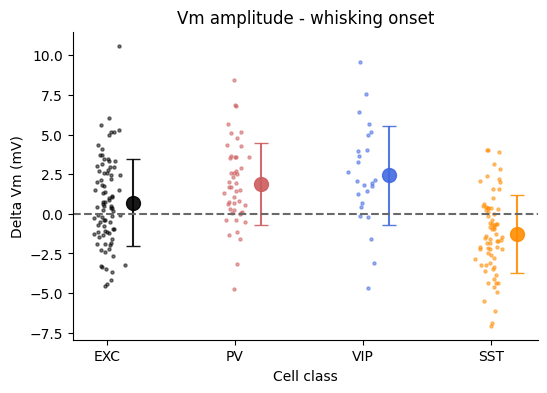

In [15]:
fig, ax = plt.subplots(1,1,figsize=(6,4), dpi=100) #define 1x1 figure layout 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for idx, c_type in enumerate(cell_class_order):
    
    data_points = np.array(result_df[result_df.cell_type==c_type]['delta_vm'])
    n_points = data_points.shape[0]
    points_locs = [idx] * n_points
    
    jitter_scatterplot(points_locs, data_points, s=5, alpha=0.5, c=class_color[c_type])
    ax.errorbar(idx+0.2,
            np.nanmean(data_points),
            yerr=np.nanstd(data_points), 
            marker='o', ms=10, capsize=5,
            alpha=0.9, c=class_color[c_type]
                    )

# Set xtick labels and legend
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cell_class_order)
ax.set_xlabel('Cell class')
ax.set_ylabel('Delta Vm (mV)')
ax.set_title('Vm amplitude - whisking onset');
ax.axhline(y=0, ls='--', c='dimgray')


# Save figure
fname = os.path.join(figure_path, '10_delta_vm_whisking_onset.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')
    

In [16]:
# stats comparison between cell types (Tukey's HSD test)
from scipy.stats import tukey_hsd
from scipy.stats import wilcoxon

Obs_EXC = result_df[result_df.cell_type=='EXC']['delta_vm'].values
Obs_PV = result_df[result_df.cell_type=='PV']['delta_vm'].values
Obs_VIP = result_df[result_df.cell_type=='VIP']['delta_vm'].values
Obs_SST = result_df[result_df.cell_type=='SST']['delta_vm'].values

nan_ids = np.isnan(Obs_EXC)
Obs_EXC= Obs_EXC[~nan_ids]
nan_ids = np.isnan(Obs_PV)
Obs_PV= Obs_PV[~nan_ids]
nan_ids = np.isnan(Obs_VIP)
Obs_VIP= Obs_VIP[~nan_ids]
nan_ids = np.isnan(Obs_SST)
Obs_SST= Obs_SST[~nan_ids]

# test the significance for each cell type

Res=wilcoxon(Obs_EXC)
print('EXC', Res)
Res=wilcoxon(Obs_PV)
print('PV', Res)
Res=wilcoxon(Obs_VIP)
print('VIP', Res)
Res=wilcoxon(Obs_SST)
print('SST', Res)
print('')
# compare between cell types
Res=tukey_hsd(Obs_EXC, Obs_PV, Obs_VIP, Obs_SST)
print(Res)

EXC WilcoxonResult(statistic=1358.0, pvalue=0.03966336705699179)
PV WilcoxonResult(statistic=151.0, pvalue=3.1637799366990293e-06)
VIP WilcoxonResult(statistic=43.0, pvalue=0.0007149577140808105)
SST WilcoxonResult(statistic=575.0, pvalue=9.370777948714103e-05)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -1.167     0.083    -2.434     0.100
 (0 - 2)     -1.709     0.029    -3.295    -0.123
 (0 - 3)      1.986     0.000     0.861     3.111
 (1 - 0)      1.167     0.083    -0.100     2.434
 (1 - 2)     -0.542     0.848    -2.267     1.184
 (1 - 3)      3.154     0.000     1.839     4.468
 (2 - 0)      1.709     0.029     0.123     3.295
 (2 - 1)      0.542     0.848    -1.184     2.267
 (2 - 3)      3.695     0.000     2.071     5.319
 (3 - 0)     -1.986     0.000    -3.111    -0.861
 (3 - 1)     -3.154     0.000    -4.468    -1.839
 (3 - 2)     -3.695     0.000    -5.319    -2.071



## Compare mean firing rate before and after whisking onset

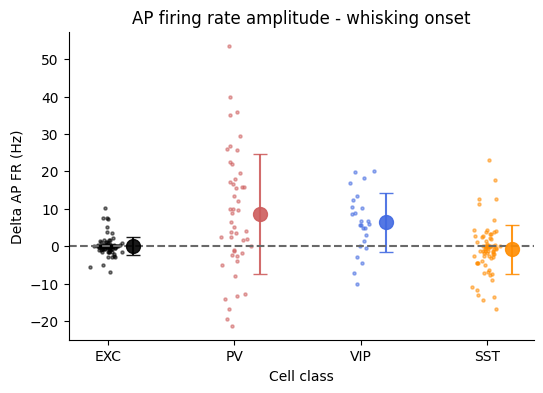

In [17]:
fig, ax = plt.subplots(1,1,figsize=(6,4), dpi=100) #define 1x1 figure layout 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for idx, c_type in enumerate(cell_class_order):
    
    data_points = np.array(result_df[result_df.cell_type==c_type]['delta_ap'])
    n_points = data_points.shape[0]
    points_locs = [idx] * n_points
    
    jitter_scatterplot(points_locs, data_points, s=5, alpha=0.5, c=class_color[c_type])
    ax.errorbar(idx+0.2,
            np.nanmean(data_points),
            yerr=np.nanstd(data_points), 
            marker='o', ms=10, capsize=5,
            alpha=0.9, c=class_color[c_type]
                    )

# Set xtick labels and legend
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(cell_class_order)
ax.set_xlabel('Cell class')
ax.set_ylabel('Delta AP FR (Hz)')
ax.set_title('AP firing rate amplitude - whisking onset');
ax.axhline(y=0, ls='--', c='dimgray')


# Save figure
fname = os.path.join(figure_path, '11_delta_ap_fr_whisking_onset.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')
    

In [18]:
# stats comparison between cell types (Tukey's HSD test)
from scipy.stats import tukey_hsd
from scipy.stats import wilcoxon

Obs_EXC = result_df[result_df.cell_type=='EXC']['delta_ap'].values
Obs_PV = result_df[result_df.cell_type=='PV']['delta_ap'].values
Obs_VIP = result_df[result_df.cell_type=='VIP']['delta_ap'].values
Obs_SST = result_df[result_df.cell_type=='SST']['delta_ap'].values

nan_ids = np.isnan(Obs_EXC)
Obs_EXC= Obs_EXC[~nan_ids]
nan_ids = np.isnan(Obs_PV)
Obs_PV= Obs_PV[~nan_ids]
nan_ids = np.isnan(Obs_VIP)
Obs_VIP= Obs_VIP[~nan_ids]
nan_ids = np.isnan(Obs_SST)
Obs_SST= Obs_SST[~nan_ids]

# test the significance for each cell type

Res=wilcoxon(Obs_EXC)
print('EXC', Res)
Res=wilcoxon(Obs_PV)
print('PV', Res)
Res=wilcoxon(Obs_VIP)
print('VIP', Res)
Res=wilcoxon(Obs_SST)
print('SST', Res)
print('')
# compare between cell types
Res=tukey_hsd(Obs_EXC, Obs_PV, Obs_VIP, Obs_SST)
print(Res)

EXC WilcoxonResult(statistic=718.5, pvalue=0.6660711524900296)
PV WilcoxonResult(statistic=242.0, pvalue=0.0011093234651683918)
VIP WilcoxonResult(statistic=38.0, pvalue=0.0013742758758316942)
SST WilcoxonResult(statistic=736.0, pvalue=0.13237644116843508)



/Users/wesleymonteith/miniconda3/envs/malm/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -8.541     0.000   -12.657    -4.425
 (0 - 2)     -6.250     0.010   -11.402    -1.098
 (0 - 3)      0.883     0.924    -2.771     4.538
 (1 - 0)      8.541     0.000     4.425    12.657
 (1 - 2)      2.291     0.715    -3.314     7.896
 (1 - 3)      9.424     0.000     5.154    13.694
 (2 - 0)      6.250     0.010     1.098    11.402
 (2 - 1)     -2.291     0.715    -7.896     3.314
 (2 - 3)      7.133     0.003     1.858    12.409
 (3 - 0)     -0.883     0.924    -4.538     2.771
 (3 - 1)     -9.424     0.000   -13.694    -5.154
 (3 - 2)     -7.133     0.003   -12.409    -1.858



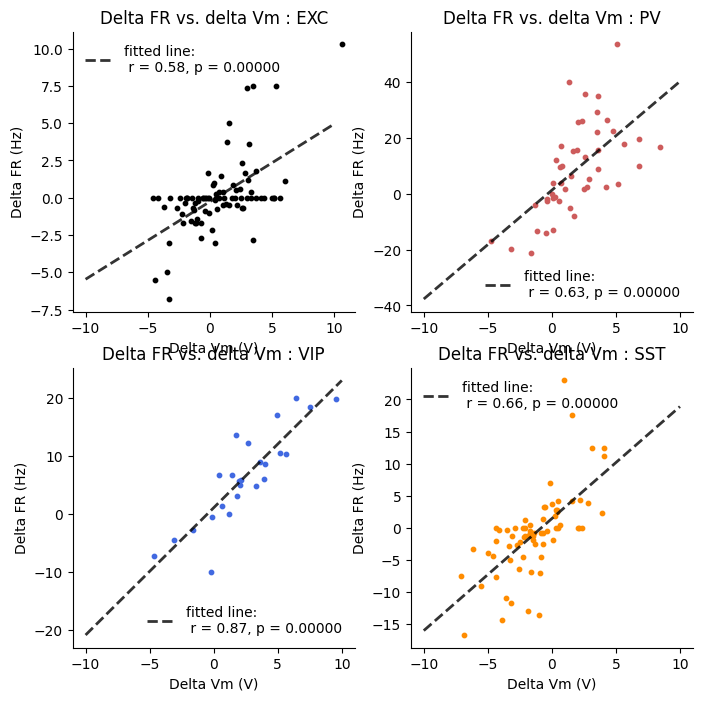

In [19]:
# Correlation of change in firing rate vs change in Vm
#Define 1x4 plot to show each cell type
fig, axs = plt.subplots(2,2, figsize=(8,8), dpi=100,
                       sharey=False)
for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

for idx, c_type in enumerate(cell_class_order):
    
    #fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4), dpi=100)
    #remove_top_right_frame(ax)
    
    Y = np.array(result_df[result_df.cell_type==c_type]['delta_ap'])
    X = np.array(result_df[result_df.cell_type==c_type]['delta_vm'])
    
    a=int(np.floor(idx/2))
    b=int(idx%2)

    axs[a, b].scatter(X, 
               Y,
               s=10, 
               alpha=1, 
               c=class_color[c_type])
    # set Y limites
    #plt.ylim(-2.5, 2.5)
    # Axes
    axs[a, b].set_xlabel('Delta Vm (V)')
    axs[a, b].set_ylabel('Delta FR (Hz)')
    axs[a, b].set_title('Delta FR vs. delta Vm : {}'.format(c_type))
    
    # Fit linear regression model and plot regression line
    nan_ids = np.isinf(X) + np.isnan(Y) #finding NaNs 

    X_fit=X[~nan_ids]
    Y_fit=Y[~nan_ids]
    model = LinearRegression().fit(X_fit.reshape(-1, 1), #must be 2D 
                               Y_fit)
    
    x_range=np.array((-10, 10))
    y_fit = model.intercept_ + model.coef_[0] * x_range

    result = scipy.stats.linregress(X_fit, Y_fit)

    axs[a,b].plot(x_range, 
            y_fit, 
            ls='--', 
            linewidth=2,
            color='k',
            label='fitted line: \n r = {:.2f}, p = {:.5f}'.format(result.rvalue, result.pvalue), 
            alpha=0.8)
    axs[a,b].legend(frameon=False)

# Save figure
fname = os.path.join(figure_path, '12_delta_FRvsdelta_Vm.png')
plt.savefig(fname=fname, dpi='figure', format='png', bbox_inches='tight')

**End of notebook**.